In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import time

from core import qlearning as q
from core import prices as pr


## Variation du $\beta$:

Intuition : 
- Plus le $\epsilon$ tend vite vers 0 ($\beta$ grand), plus on optimise, plus les profits vont être ceux de Nash
- Il y aura une valeur de $\beta$ moyenne pour lequelle il y aura collusion 
- Si $\epsilon$ trop proche de 1, tend vers 0 trop lentement ($\beta$ très petit) il n'y aura pas de stratégie (tout le temps action aléatoire)


In [3]:
start = time.time()
aggregated_agents = []
for beta in [10**(-6),10**(-5),10**(-4),10**(-3)]:
    total_rewards = []

    for loop in range(3):
        print("Loop:", loop, "beta:", beta)
        agents = [q.Agent(beta=beta) for _ in range(2)]
        env = q.Env()

        temps = []
        rewards = []
        epsilon = []
        prices = []

        # Initialisation des prix p0 (on va le faire directement dans chaque agent)
        for agent in agents:
            agent.p = np.random.choice(agent.A)

        # Initialisation de l'état
        s_t = env([agent.p for agent in agents])[1]
        for agent in agents:
            agent.s_t = s_t

        s_ind = agents[0].find_index(agents[0].s_t)
        for agent in agents:
            agent.s_ind = s_ind

        # Phase itérative
        for t in range(1000):
            # Actions et état t+1
            for agent in agents:
                agent.a_ind = agent.get_next_action()

            s_t1 = env([agent.A[agent.a_ind] for agent in agents])[1]
            for agent in agents:
                agent.s_t1 = s_t1

            s_ind1 = agents[0].find_index(agents[0].s_t1)
            for agent in agents:
                agent.s_ind1 = s_ind1

            temps.append(t)
            ret = env(s_t1)
            quant, price, cost = ret

            re = ret[0]*ret[1]-ret[0]*ret[2]
            rewards.append(re)
            epsilon_values = [agent.epsilon for agent in agents]
            epsilon.append(epsilon_values)
            prices.append([agent.p for agent in agents])

            for i, agent in enumerate(agents):
                agent.updateQ(q=quant[i], p=price[i], c=cost[i], t=t)

        total_rewards.append(rewards)

    aggregated_agents.append(np.array(total_rewards).mean(axis=0))
end = time.time()

print(aggregated_agents)
print(end-start)

Loop: 0 beta: 1e-06
Loop: 1 beta: 1e-06
Loop: 2 beta: 1e-06
Loop: 0 beta: 1e-05
Loop: 1 beta: 1e-05
Loop: 2 beta: 1e-05
Loop: 0 beta: 0.0001
Loop: 1 beta: 0.0001
Loop: 2 beta: 0.0001
Loop: 0 beta: 0.001
Loop: 1 beta: 0.001
Loop: 2 beta: 0.001
[array([[0.26956241, 0.31525572],
       [0.29801742, 0.27884357],
       [0.18539595, 0.29611232],
       ...,
       [0.26265838, 0.28914625],
       [0.34094506, 0.19699118],
       [0.29378793, 0.22370949]]), array([[0.33984808, 0.24473819],
       [0.22114718, 0.30690449],
       [0.31548242, 0.25237731],
       ...,
       [0.28869144, 0.23729804],
       [0.31044091, 0.18183993],
       [0.27909929, 0.26420339]]), array([[0.28372837, 0.34887557],
       [0.32712945, 0.25119559],
       [0.27316219, 0.29328274],
       ...,
       [0.22479152, 0.26760249],
       [0.33463529, 0.20115262],
       [0.28424597, 0.2747155 ]]), array([[0.27944632, 0.28251436],
       [0.26478696, 0.34051171],
       [0.29829372, 0.27285333],
       ...,
       [0

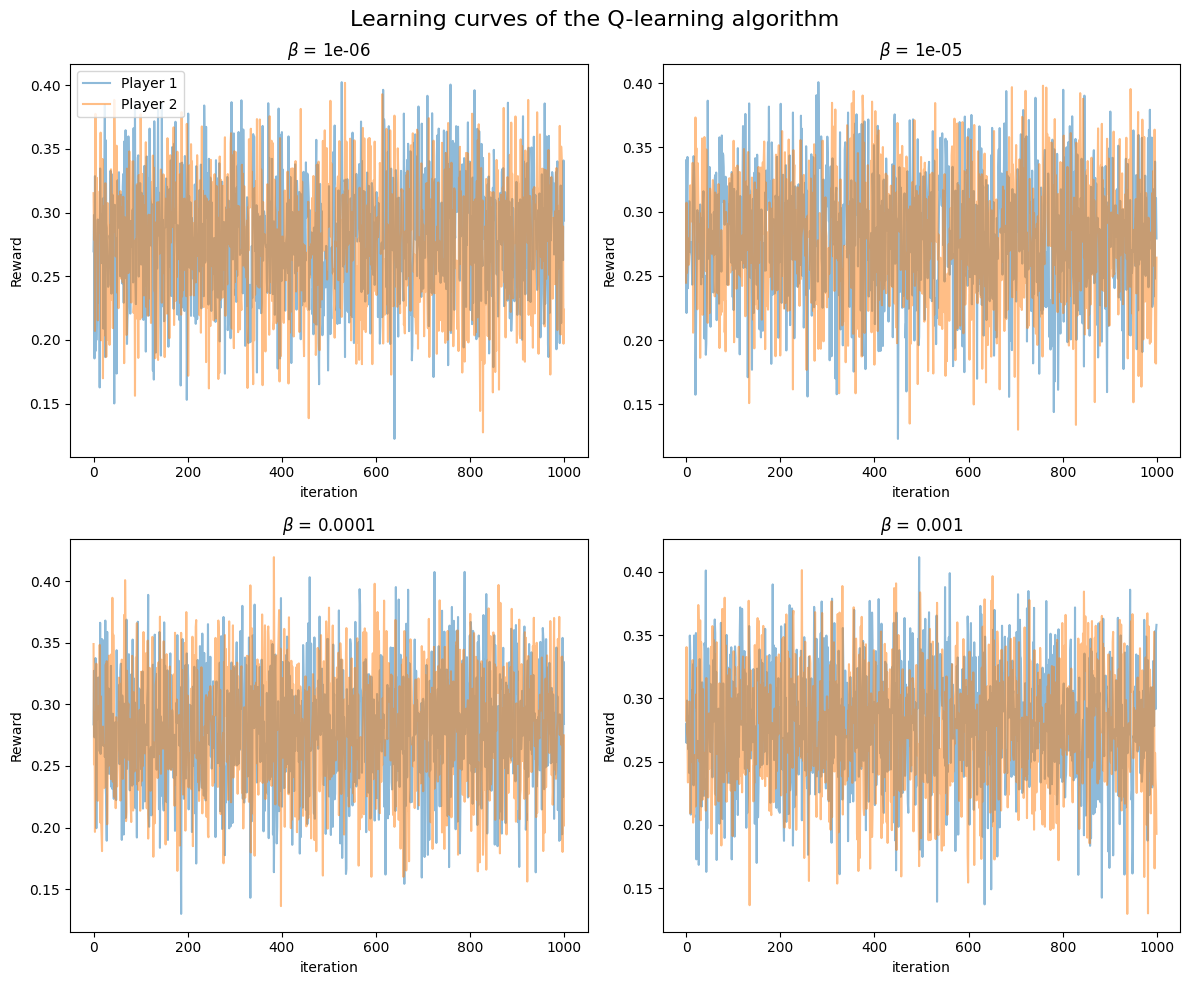

In [7]:
num_players = 2
num_graphs = len(aggregated_agents)
beta = [10**(-6),10**(-5),10**(-4),10**(-3)]

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax = axes[graph_num]
    num_players = len(aggregated_agents[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
        ax.plot(aggregated_agents[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
    
    # Set the title of the subplot with the corresponding period
    ax.set_title(f'$\\beta$ = {beta[graph_num]}')
    
    # Set the labels of the subplot
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')

    # Add a legend to the first subplot
    if graph_num == 0:
        ax.legend(loc='upper left') 

# Remove any unused subplots
if num_graphs < 4:
    for i in range(num_graphs, 4):
        fig.delaxes(axes[i])

# Create a legend in the first subplot
if graph_num == 0:
         # Legend in the top-left corner
        ax.spines['top'].set_visible(True)  # Show top spine
        ax.spines['right'].set_visible(True)  # Show right spine
        ax.spines['bottom'].set_visible(True)  # Show bottom spine
        ax.spines['left'].set_visible(True)  # Show left spine

# Get the legend handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()


fig.suptitle('Learning curves of the Q-learning algorithm', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

In [8]:
prices = pr.PriceOptimizer()
collusion_profit, collusion_prices = prices.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()
RN = nash_profit
RC = collusion_profit
    
Rmean = np.zeros((len(aggregated_agents), 2))
DRmean = np.zeros((len(aggregated_agents), 2))   
    
for i in range (len(aggregated_agents)): 
    for j in range (2):
        Rmean[i][j] = aggregated_agents[i][-100:,j].mean()
        DRmean[i][j] = (Rmean[i][j] - RN)/(RC - RN) 

print(DRmean)

[[0.53295105 0.52544315]
 [0.51402724 0.46799282]
 [0.47134622 0.5340246 ]
 [0.49480814 0.47465103]]


[0.5291971  0.49101003 0.50268541 0.48472959]


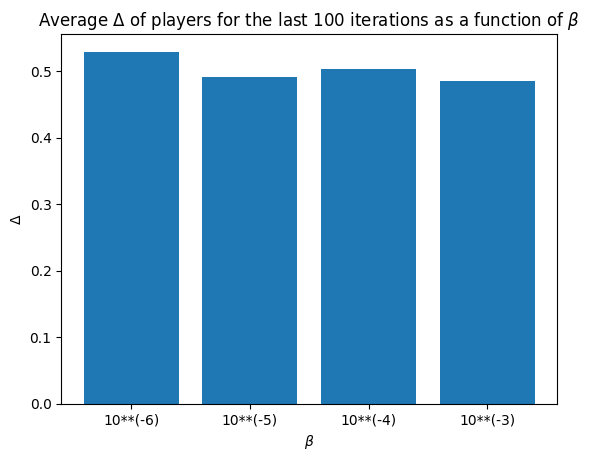

In [9]:
av = np.mean(DRmean, axis=1)
print(av)
plt.bar(['10**(-6)','10**(-5)','10**(-4)','10**(-3)'],av)
plt.xlabel('$\\beta$')
plt.ylabel('$\\Delta$')
plt.title('Average $\\Delta$ of players for the last 100 iterations as a function of $\\beta$')
plt.show()